In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Exploratory Data Analysis

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Deleting columns which not needed in modeling and removing na values from rows
def drop_cols(col, df):
    return df.drop(col, axis = 1, inplace = True)

cols_drop = ['PassengerId', 'Cabin', 'Name', 'Ticket' ]
drop_cols(cols_drop, train) # Dropping rows which doesnot add value to the model
train.Age = train.Age.fillna(train.Age.mean()) # replacing nan values with age mean
train.dropna(inplace = True)


In [9]:
# Similar data cleaning with test dataset
# drop_cols(cols_drop, test)
# test.Age = train.Age.fillna(test.Age.mean())
# test.dropna(inplace = True)

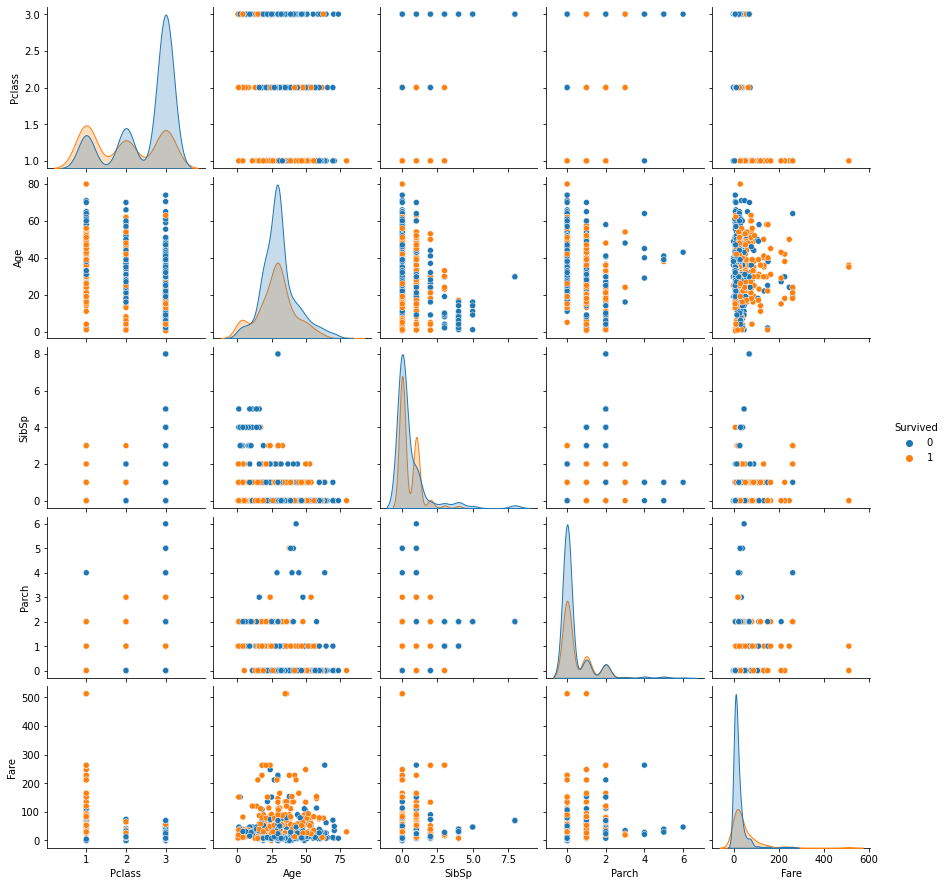

In [10]:
# Visualizing data using pairplot 
sns.pairplot(data = train, hue = 'Survived')

In [11]:
# Model building

train_oh_coded = pd.get_dummies(train , columns = ['Sex', 'Pclass', 'Embarked'])
y = train_oh_coded['Survived']
x = train_oh_coded.drop('Survived', axis = 1)

In [12]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.335549,-0.074673,-0.034040,0.083151,0.255290
Pclass,-0.335549,1.000000,-0.327954,0.081656,0.016824,-0.548193
Age,-0.074673,-0.327954,1.000000,-0.231875,-0.178232,0.088604
SibSp,-0.034040,0.081656,-0.231875,1.000000,0.414542,0.160887
Parch,0.083151,0.016824,-0.178232,0.414542,1.000000,0.217532
Fare,0.255290,-0.548193,0.088604,0.160887,0.217532,1.000000


In [13]:
train_oh_coded.corr()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.074673,-0.034040,0.083151,0.255290,0.541585,-0.541585,0.282368,0.095002,-0.320171,0.169966,0.004536,-0.151777
Age,-0.074673,1.000000,-0.231875,-0.178232,0.088604,-0.089434,0.089434,0.315984,0.008416,-0.278527,0.033853,-0.012823,-0.021589
SibSp,-0.034040,-0.231875,1.000000,0.414542,0.160887,0.116348,-0.116348,-0.052894,-0.056507,0.091515,-0.060074,-0.026692,0.069438
Parch,0.083151,-0.178232,0.414542,1.000000,0.217532,0.247508,-0.247508,-0.015809,-0.001278,0.014634,-0.011588,-0.081585,0.061512
Fare,0.255290,0.088604,0.160887,0.217532,1.000000,0.179958,-0.179958,0.590576,-0.117609,-0.411932,0.270731,-0.116684,-0.163758
Sex_female,0.541585,-0.089434,0.116348,0.247508,0.179958,1.000000,-1.000000,0.093142,0.066459,-0.134227,0.084520,0.075217,-0.121405
Sex_male,-0.541585,0.089434,-0.116348,-0.247508,-0.179958,-1.000000,1.000000,-0.093142,-0.066459,0.134227,-0.084520,-0.075217,0.121405
Pclass_1,0.282368,0.315984,-0.052894,-0.015809,0.590576,0.093142,-0.093142,1.000000,-0.287653,-0.625395,0.299472,-0.154680,-0.165022
Pclass_2,0.095002,0.008416,-0.056507,-0.001278,-0.117609,0.066459,-0.066459,-0.287653,1.000000,-0.567432,-0.126039,-0.127705,0.190824
Pclass_3,-0.320171,-0.278527,0.091515,0.014634,-0.411932,-0.134227,0.134227,-0.625395,-0.567432,1.000000,-0.154785,0.237035,-0.013594


<AxesSubplot:>

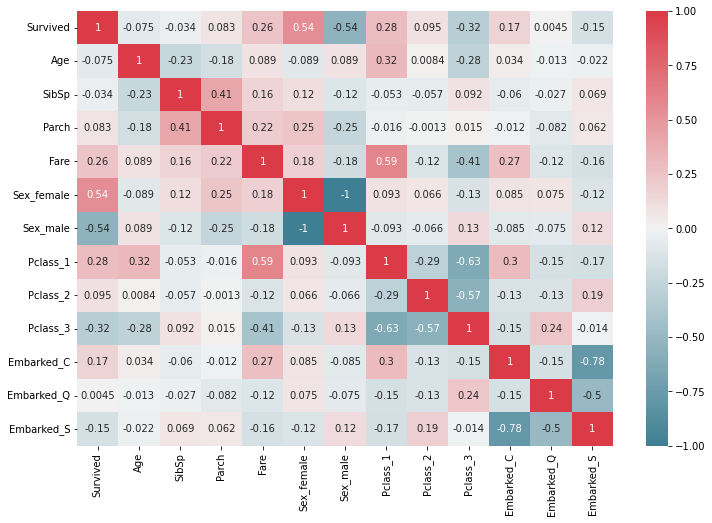

In [14]:
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True)
sns.heatmap(train_oh_coded.corr(), cmap = cmap, annot = True)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [16]:
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

In [17]:
dt = DecisionTreeClassifier(max_depth =  8, min_samples_leaf = 10, max_features = 'log2')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
s = accuracy_score(y_pred, y_test)
print('Decision Tree Classifier accuracy is : ', round(s, 4))

Decision Tree Classifier accuracy is :  0.7921


In [18]:
# def model_training(model, x_train, y_train, x_test, y_test):
#     model.fit(x_train, y_train)
#     pred = model.predict(x_test)
#     return f'Accurcy of the {model} model is: {accuracy_score(y_test, pred).round(3)}'
dt = DecisionTreeClassifier(max_depth = 6)
dt.fit(x_train, y_train)
pred = dt.predict(x_test)
print(f'Accurcy of the {dt} model is: {accuracy_score(y_test, pred).round(3)}')

Accurcy of the DecisionTreeClassifier(max_depth=6) model is: 0.792


In [19]:
confusion_matrix(y_test, pred)

array([[91, 18],
       [19, 50]])

In [20]:
# Confusion Matrix
#pd.crosstab(y_test, dt.predict(x_test) ,rownames=['Actual_values'], colnames=['Predicted_values'])

In [21]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 6, random_state = 1)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(f'Accurcy of the {rf} model is: {accuracy_score(y_test, pred).round(3)}')

Accurcy of the RandomForestClassifier(max_depth=6, random_state=1) model is: 0.809


In [22]:
# Confusion Matrix
pd.crosstab(y_test, rf.predict(x_test) ,rownames=['Actual_values'], colnames=['Predicted_values'])

Predicted_values,0,1
Actual_values,,
0,95,14
1,20,49


## Cross Validation 

In [23]:
cv_val = StratifiedKFold(n_splits = 8)

In [24]:
# Cross validation of Decision tree model
cv = cross_val_score(dt, x_train, y_train, cv = cv_val)
print('Mean accuracy is : ', cv.mean())
cv

Mean accuracy is :  0.8185489019407559


array([0.80898876, 0.74157303, 0.85393258, 0.80898876, 0.83146067,
       0.85393258, 0.84269663, 0.80681818])

In [25]:
# Cross validation of Random Forest model
cv = cross_val_score(rf, x_train, y_train, cv = cv_val)
print('Mean accuracy is : ', cv.mean())
cv

Mean accuracy is :  0.8283963227783453


array([0.82022472, 0.7752809 , 0.87640449, 0.82022472, 0.85393258,
       0.79775281, 0.86516854, 0.81818182])

## Hyperparameter Tuning

In [26]:
#Hyper parameter tuning - Descision tree

params = {'max_depth': [2,3,5,8,10],
            'min_samples_leaf': [5, 10, 15],
            'criterion' : ['gini', 'entropy']}

grid_search_dt = GridSearchCV(estimator = dt, 
                              param_grid = params,
                              cv=4, n_jobs = -1, verbose = 1, scoring = 'accuracy')
grid_search_dt.fit(x_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=6), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 8, 10],
                         'min_samples_leaf': [5, 10, 15]},
             scoring='accuracy', verbose=1)

In [27]:
grid_search_dt.best_estimator_, grid_search_dt.best_score_

(DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10),
 0.8100679235701137)

In [28]:
#Hyper parameter tuning - Random Forest

rf_params = {'max_depth': [None], 
             'min_samples_split':[2,5,8],
            'min_samples_leaf': [1,3,8],
            'n_estimators':[50,10, 150],
            'criterion': ['gini', 'entropy']}

grid_search_rf = GridSearchCV(rf, param_grid = rf_params, cv = cv_val, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_search_rf.fit(x_train, y_train)

Fitting 8 folds for each of 54 candidates, totalling 432 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(max_depth=6, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'min_samples_leaf': [1, 3, 8],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [50, 10, 150]},
             scoring='accuracy', verbose=1)

<b>Gini, Entropy:</b> Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.

<b>min_samples_leaf:</b> The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf number of samples are there in each of the left and right branches. 

In [29]:
grid_search_rf.best_estimator_, grid_search_rf.best_score_

(RandomForestClassifier(criterion='entropy', min_samples_leaf=3, n_estimators=50,
                        random_state=1),
 0.8410527323799796)

## Ploting Learning Curve 

In [30]:
learning_curve(dt, x_train, y_train, cv = 6)

(array([ 59, 192, 325, 458, 592]),
 array([[0.88135593, 0.94915254, 0.94915254, 0.96610169, 0.94915254,
         0.96610169],
        [0.91666667, 0.94270833, 0.91145833, 0.91145833, 0.90625   ,
         0.90625   ],
        [0.89846154, 0.91384615, 0.89230769, 0.89846154, 0.90153846,
         0.89538462],
        [0.88427948, 0.91266376, 0.8930131 , 0.87117904, 0.87991266,
         0.87772926],
        [0.87837838, 0.89527027, 0.88513514, 0.86317568, 0.875     ,
         0.87837838]]),
 array([[0.76470588, 0.77310924, 0.80672269, 0.78813559, 0.75423729,
         0.74576271],
        [0.80672269, 0.70588235, 0.78151261, 0.76271186, 0.70338983,
         0.71186441],
        [0.82352941, 0.74789916, 0.87394958, 0.77118644, 0.76271186,
         0.75423729],
        [0.78991597, 0.77310924, 0.82352941, 0.79661017, 0.75423729,
         0.72881356],
        [0.78991597, 0.78151261, 0.78151261, 0.80508475, 0.78813559,
         0.76271186]]))

<b>Variance-Bias trade off:</b> When building machine learning model, the model complexity defines the nature of the fit. If the model is too complex (have higher degree of precitictability) it would overfit the data. The variance of the model will too high in this case. On the other hand if the model is too simple, it will not be able fit the data properly, known as the underfitting and leads to higher bias. Thus the best would be to find a parameter that would be decreasing overall loss/error of the model and find a compromise/trade off of bias and variance.

<b>Stratyfied-Kfold:</b> It will devide the data into same kind of categorial sets. For example if the survival of people is in different proportion in different classes, then those classes will be devided evenly in different folds.